# Thompson Sampling for Contextual bandits

we expand our Multi-Armed Bandit setting such that the expected rewards $\theta$ can depend on an external variable. This scenario is known as the Contextual bandit.

## Problem: Contextual Bandit

The Contextual Bandit is just like the Multi-Armed bandit problem but now the true expected reward parameter $\theta_k$ depends on external variables. Therefore, we add the notion of context or state to support our decision.

$$ \theta_k = \frac{1}{ 1 + exp(-f(x))} $$
where 
$$ f(x) = \beta_0 + \beta_1 \times x + \epsilon $$
and 
$$ \epsilon \sim \mathcal{N}(0, \sigma^2)$$


In [11]:
# plotting inline
%matplotlib inline

# working directory
#import os; os.chdir('/home/gdmarmerola/ts_demo')

# importing necessary modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import beta as beta_dist
from scipy.stats import norm as norm_dist
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
from sklearn.linear_model import SGDClassifier, LogisticRegression
from scipy.optimize import minimize
from statsmodels.tools.tools import add_constant

import warnings
warnings.filterwarnings('ignore')

# turning off automatic plot showing, and setting style
plt.ioff()
plt.style.use('fivethirtyeight')

In [12]:
# class to implement our contextual bandit setting
class ContextualMAB:
    
    # initialization
    def __init__(self):
        
        # we build two bandits
        self.weights = {}
        self.weights[0] = [0.0, 1.6]
        self.weights[1] = [0.0, 0.4]
    
    # method for acting on the bandits
    def draw(self, k, x):
        
        # probability dict
        prob_dict = {}
        
        # loop for each bandit
        for bandit in self.weights.keys():
        
            # linear function of external variable
            f_x = self.weights[bandit][0] + self.weights[bandit][1]*x

            # generate reward with probability given by the logistic
            probability = 1/(1 + np.exp(-f_x))
            
            # appending to dict
            prob_dict[bandit] = probability
        
        # give reward according to probability
        # [reward, regret, prob]
        return np.random.choice([0,1], p=[1 - prob_dict[k], prob_dict[k]]), max(prob_dict.values()) - prob_dict[k], prob_dict[k]

In [13]:
# instance of our class
cmab = ContextualMAB()

# our x sample
X = np.linspace(-6, 6, 1500)

# computing bandit probabilities and storing to a dict
bandit_probs = {'x': X, 
                'b0': [cmab.draw(0, x_i)[2] for x_i in X], 
                'b1': [cmab.draw(1, x_i)[2] for x_i in X]}

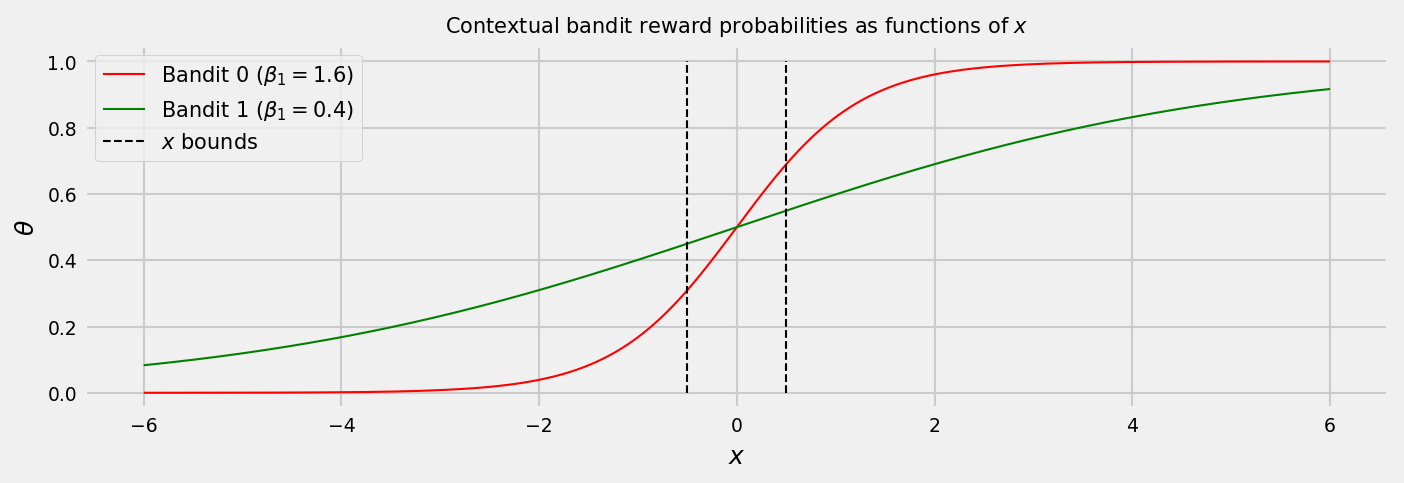

In [14]:
# clearing past figures
plt.close('all')

# colors for each bandit
bandit_colors = ['red', 'green']

# showing in a plot
plt.figure(figsize=[10,3], dpi=150)

# plotting bandit 0
plt.plot(bandit_probs['x'], bandit_probs['b0'], label='Bandit 0 ($\\beta_1 = 1.6$)', linewidth=1, color=bandit_colors[0])

# plotting bandit 1
plt.plot(bandit_probs['x'], bandit_probs['b1'], label='Bandit 1 ($\\beta_1 = 0.4$)', linewidth=1, color=bandit_colors[1])

# title and more formatting
plt.title('Contextual bandit reward probabilities as functions of $x$', fontsize=10);
plt.ylabel('$\\theta$', fontsize=12); plt.xlabel('$x$', fontsize=12)
plt.xticks(fontsize=9); plt.yticks(fontsize=9);

# showing our variable bounds [What does x bounds mean?]
plt.plot([-0.5,-0.5],[0.0,1.0],'k--',label='$x$ bounds',linewidth=1)
plt.plot([0.5,0.5],[0.0,1.0],'k--',linewidth=1)

# showing
plt.legend(fontsize=10)
plt.show()

In [15]:
# let us create a function for the output of x
# it is a sine wave with period equal to 50 draws
# we're going to limit the amplitude of the sine wave such that the probabilities are not much different
def get_context(draw_number):
    return np.sin(draw_number*2*np.pi/100)*0.5


# we will use a random decision policy for illustration purposes
class RandomPolicy:
    
    # initializing
    def __init__(self, n_bandits):
        self.n_bandits = n_bandits
    
    # random bandit choice
    def choose_bandit(self, round_df, x):
        return np.random.choice(range(self.n_bandits),1)[0]  # selected bandit

In [16]:
# function for plotting 
def plot_CMAB_experiment(decision_policy, N_DRAWS, plot_title):

    # clearing past figures
    plt.close('all')

    # Contextual MAB object
    cmab = ContextualMAB()

    # number of bandits
    N_BANDITS = len(cmab.weights.keys())

    # lists for accumulating draws, bandit choices and rewards
    k_list = []
    reward_list = []

    # df for accumulating draws and results
    round_df = pd.DataFrame({'k': [], 'x': [], 'reward': []})

    # colors for each bandit
    bandit_colors = ['red', 'green']

    # opening figure
    fig = plt.figure(figsize=(9,5), dpi=150)

    # let us position our plots in a grid, the largest being our plays
    ax1 = plt.subplot2grid((5, 4), (0, 0), colspan=4, rowspan=3)
    ax2 = plt.subplot2grid((5, 4), (3, 0), colspan=4, rowspan=2)

    # loop generating draws
    for draw_number in range(N_DRAWS):

        # record information about this draw
        x = get_context(draw_number)
        k = decision_policy(round_df, x)
        reward, regret, prob = cmab.draw(k, x)

        # record information about this draw
        k_list.append(k)
        reward_list.append(reward)

        # getting list of colors that tells us the bandit
        color_list = [bandit_colors[k] for k in k_list]

        # getting list of facecolors that tells us the reward
        facecolor_list = [['none', bandit_colors[k_list[i]]][r] for i, r in enumerate(reward_list)]
        
        # temporary df with data from this round
        temp_df = pd.DataFrame({'x': x, 'k': k, 'reward': reward}, index=[draw_number])
        
        # accumulating in main df
        round_df = pd.concat([round_df, temp_df])

    # fixing properties of the plots
    ax1.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))
    ax1.set_title(plot_title, fontsize=10)
    ax1.set_xlabel('Round', fontsize=10); ax1.set_ylabel('Bandit', fontsize=10)
    ax2.set_title('Value of the context variable $x$', fontsize=10)
    ax2.set_xlabel('Round', fontsize=10); ax2.set_ylabel('$x$', fontsize=10)
    ax2.set(xlim=(-1, N_DRAWS))

    # titles of distribution plots

    # initializing with first data
    scatter = ax1.scatter(y=[k_list[0]], x=[list(range(N_DRAWS))[0]], color=[color_list[0]], linestyle='-', marker='o', s=30, facecolor=[facecolor_list[0]]);
    x_line = ax2.plot(list(range(N_DRAWS)), [get_context(i) for i in range(N_DRAWS)], 'k--', linewidth=2)

    # filling area to show optimal action at each point
    ax1.fill_between(x=[0,50], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[0], alpha=0.05)
    ax1.fill_between(x=[50,100], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[1], alpha=0.05)
    ax1.fill_between(x=[100,150], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[0], alpha=0.1)
    ax1.fill_between(x=[150,200], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[1], alpha=0.1)

    # filling area to show optimal action at each point
    ax2.fill_between(x=[0,50], y1=[1,1], y2=[-1,-1], color=bandit_colors[0], alpha=0.1)
    ax2.fill_between(x=[50,100], y1=[1,1], y2=[-1,-1], color=bandit_colors[1], alpha=0.1)
    ax2.fill_between(x=[100,150], y1=[1,1], y2=[-1,-1], color=bandit_colors[0], alpha=0.1)
    ax2.fill_between(x=[150,200], y1=[1,1], y2=[-1,-1], color=bandit_colors[1], alpha=0.1)

    # titles
    #plt.title('Random draws from the row of slot machines (MAB)', fontsize=10)
    #plt.xlabel('Round', fontsize=10); plt.ylabel('Bandit', fontsize=10);

    # function for updating
    def animate(i):

        # clearing axes
        ax1.clear(); 

        # updating game rounds
        scatter = ax1.scatter(y=k_list[:i], x=list(range(N_DRAWS))[:i], color=color_list[:i], 
                              linestyle='-', marker='o', s=30, facecolor=facecolor_list[:i]);

        # filling area to show optimal action at each point
        ax1.fill_between(x=[0,50], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[0], alpha=0.1)
        ax1.fill_between(x=[50,100], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[1], alpha=0.1)
        ax1.fill_between(x=[100,150], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[0], alpha=0.1)
        ax1.fill_between(x=[150,200], y1=[1.5,1.5], y2=[-0.5,-0.5], color=bandit_colors[1], alpha=0.1)

        # fixing properties of the plot
        ax1.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))
        ax1.set_title(plot_title, fontsize=10)
        ax1.set_xlabel('Round', fontsize=10); ax1.set_ylabel('Bandit', fontsize=10)
        ax2.set_title('Value of the context variable $x$', fontsize=10)
        ax2.set_xlabel('Round', fontsize=10); ax2.set_ylabel('$x$', fontsize=10)
        ax2.set(xlim=(-1, N_DRAWS))

        # do not need to return 
        return ()

    # function for creating animation
    anim = FuncAnimation(fig, animate, frames=N_DRAWS, interval=200, blit=True)

    # fixing the layout
    fig.tight_layout()

    # showing
    return HTML(anim.to_html5_video())
    #return round_df

In [17]:
# instance of random policy
rand_policy = RandomPolicy(n_bandits=2)

# plotting
plot_CMAB_experiment(rand_policy.choose_bandit, 200, 'Random draws from the Contextual MAB setting')

## Strategy: $\epsilon$-greedy with regular Logistic Regression

We try to learn the logistic function behind each bandit, And select the bandit which maximizes $\theta_k$, except when, with probability $\epsilon$, we select a random action (excluding the greedy action).

In [27]:
# Logistic Regression with e-greedy policy class
class EGreedyLR:
    
    # initialization
    def __init__(self, epsilon, n_bandits, buffer_size=200):
    
        # storing epsilon, number of bandits, and buffer size
        self.epsilon = epsilon
        self.n_bandits = n_bandits
        self.buffer_size = buffer_size
    
    # function to fit and predict from a df
    def fit_predict(self, data, actual_x):
        
        # sgd object
        logreg = LogisticRegression(fit_intercept=False)
        
        # fitting to data
        x = data['x'].values.reshape(-1,1)
        y = data['reward']
        # print("data=> x=", x, "y=", y)
        logreg.fit(data['x'].values.reshape(-1,1), data['reward'])
        
        # returning probabilities
        return logreg.predict_proba(actual_x.reshape(-1,1))[0][1]
    
    # decision function
    def choose_bandit(self, round_df, actual_x):
        
        # enforcing buffer size
        round_df = round_df.tail(self.buffer_size)
        
        # if we have enough data, calculate best bandit
        if round_df.groupby(['k','reward']).size().shape[0] == 4:
        
            # predictinng for two of our datasets
            bandit_scores = round_df.groupby('k').apply(self.fit_predict, actual_x=actual_x) # guess reward
            # print("reward=", bandit_scores)
            # get best bandit
            best_bandit = int(bandit_scores.idxmax())
        
        # if we do not have, the best bandit will be random
        else:
            best_bandit = int(np.random.choice(list(range(self.n_bandits)),1)[0])
        
        # choose greedy or random action based on epsilon
        if np.random.random() > self.epsilon:
            return best_bandit
        else:
            return int(np.random.choice(np.delete(list(range(self.n_bandits)), best_bandit),1)[0])

In [28]:
# instance of class
egreedy_lr = EGreedyLR(epsilon=0.1, n_bandits=2)

# plotting
plot_CMAB_experiment(egreedy_lr.choose_bandit, 200, '$\epsilon$-greedy strategy decisions over time')

## Strategy: Thompson with online logistic regression

In 2011, Chapelle & Li published the paper "[An Empirical Evaluation of Thompson Sampling](https://proceedings.neurips.cc/paper_files/paper/2011/file/e53a0a2978c28872a4505bdb51db06dc-Paper.pdf)"

In [ ]:
# defining a class for our online bayesian logistic regression
class OnlineLogisticRegression:
    
    # initializing
    def __init__(self, lambda_, alpha, n_dim):
        
        # the only hyperparameter is the deviation on the prior (L2 regularizer)
        self.lambda_ = lambda_; self.alpha = alpha
                
        # initializing parameters of the model
        self.n_dim = n_dim, 
        self.m = np.zeros(self.n_dim)
        self.q = np.ones(self.n_dim) * self.lambda_
        
        # initializing weights
        self.w = np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)
        
    # the loss function
    def loss(self, w, *args):
        X, y = args
        return 0.5 * (self.q * (w - self.m)).dot(w - self.m) + np.sum([np.log(1 + np.exp(-y[j] * w.dot(X[j]))) for j in range(y.shape[0])])
        
    # the gradient
    def grad(self, w, *args):
        X, y = args
        return self.q * (w - self.m) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis=0)
    
    # method for sampling weights
    def get_weights(self):
        return np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)
    
    # fitting method
    def fit(self, X, y):
                
        # step 1, find w
        self.w = minimize(self.loss, self.w, args=(X, y), jac=self.grad, method="L-BFGS-B", options={'maxiter': 20, 'disp':True}).x
        self.m = self.w
        
        # step 2, update q
        P = (1 + np.exp(-1*X.dot(self.m))) ** (-1)
        self.q = self.q + (P*(1-P)).dot(X ** 2)
                
    # probability output method, using weights sample
    def predict_proba(self, X, mode='sample'):
        
        # adding intercept to X
        #X = add_constant(X)
        
        # sampling weights after update
        self.w = self.get_weights()
        
        # using weight depending on mode
        if mode == 'sample':
            w = self.w # weights are samples of posteriors
        elif mode == 'expected':
            w = self.m # weights are expected values of posteriors
        else:
            raise Exception('mode not recognized!')
        
        # calculating probabilities
        proba = 1 / (1 + np.exp(-1 * X.dot(w)))
        return np.array([1-proba , proba]).T

In [ ]:
# now, we define a class for our policy
class ThompsonSamplingLR:
    
    # initializing policy parameters
    def __init__(self, lambda_, alpha, n_bandits, buffer_size=200):
        
        # storing the parameters
        self.lambda_ = lambda_
        self.n_bandits = n_bandits
        self.alpha = alpha
        self.buffer_size = buffer_size
    
    # function to fit and predict from a df
    def fit_predict(self, data, actual_x):
        
        # sgd object
        olr = OnlineLogisticRegression(self.lambda_, self.alpha, 1)
        
        # fitting to data
        olr.fit(data['x'].values.reshape(-1,1), data['reward'].values)
            
        # data frame with probabilities and model parameters
        out_df = pd.DataFrame({'prob': olr.predict_proba(np.array(actual_x))[0][1],
                               'm': olr.m, 'q': olr.q * (self.alpha) ** (-1.0)})
            
        # returning probabilities
        return out_df
    
    # decision function
    def choose_bandit(self, round_df, actual_x):
        
        # enforcing buffer size
        round_df = round_df.tail(self.buffer_size)
        
        # if we have enough data, calculate best bandit
        if round_df.groupby(['k','reward']).size().shape[0] == 4:
        
            # predictinng for two of our datasets
            self.ts_model_df = (round_df
                                .groupby('k')
                                .apply(self.fit_predict, actual_x=actual_x)
                                .reset_index().drop('level_1', axis=1).set_index('k'))

            # get best bandit
            best_bandit = int(self.ts_model_df['prob'].idxmax())
        
        # if we do not have, the best bandit will be random
        else:
            best_bandit = int(np.random.choice(list(range(self.n_bandits)),1)[0])
            self.ts_model_df = pd.DataFrame({'prob': 0.50, 'm': 0.0, 'q': self.lambda_}, index=[0])

        # return best bandit
        return best_bandit

In [ ]:
# instance of class
tsampling_lr = ThompsonSamplingLR(lambda_=5, alpha=5.0, n_bandits=2)

# plotting
plot_CMAB_experiment(tsampling_lr.choose_bandit, 200, 'Thompson Sampling decisions over time')

## Performance compare

## Resources

* https://gdmarmerola.github.io/ts-for-contextual-bandits/